# Import libraries

In [9]:
import os
import re
import sys
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# 1. Feature generation

In [10]:
# after your check I add this to the config file
SHOP_DUPLICATE_SET = {
    0: 57,
    1: 58,
    10: 11
}

CORRECT_CITY_NAME = {
    '!Якутск': 'Якутск',
    'РостовНаДону': 'Ростов На Дону',
    'Цифровой': 'Интернет-магазин',
    'Выездная': 'Выездная торговля',
}

FEATURE_SET = {
    'date_block_item_cnt_mean': ['date_block_num'],
    'date_block_num_item_id_item_cnt_mean': ['date_block_num', 'item_id'],
    'date_block_num_shop_id_item_cnt_mean': ['date_block_num', 'shop_id'],
    'date_block_num_item_category_id_item_cnt_mean': ['date_block_num', 'item_category_id'],
    'date_shop_category_item_cnt_mean': ['date_block_num', 'shop_id', 'item_category_id'],
    'date_shop_category_sub_type_item_cnt_mean': ['date_block_num', 'shop_id', 'category_sub_type'],
    'date_block_num_city_item_id_item_cnt_mean': ['date_block_num', 'city', 'item_id']
}

In [17]:
def load_data(path_to_data):
    """Load all data from files and return a dictionary of DataFrames."""
    sales_train_data = pd.read_csv(os.path.join(path_to_data, "sales_train.csv"))
    test_data = pd.read_csv(os.path.join(path_to_data, "test.csv")).set_index('ID')
    items_data = pd.read_csv(os.path.join(path_to_data, "items.csv"))
    item_categories_data = pd.read_csv(os.path.join(path_to_data, "item_categories.csv"))
    shops_data = pd.read_csv(os.path.join(path_to_data, "shops.csv"))
    sub_data = pd.read_csv(os.path.join(path_to_data, "sample_submission.csv"))

    data = {
        'sales_train_data': sales_train_data,
        'test_data': test_data,
        'items_data': items_data,
        'item_categories_data': item_categories_data,
        'shops_data': shops_data,
        'sub_data': sub_data
    }

    return data


def remove_outliers(data):
    """Remove outliers from sales_train_data."""
    data = data[
        (data['item_cnt_day'] < 1000) &
        (data['item_price'] < 300000) &
        (data['item_price'] > 0)
    ]
    return data


def replace_duplicate_shop_ids(data, shop_duplicate_set):
    """Replace duplicate shop IDs for sales_train_data, test_data, and shops_data."""
    for key in ['sales_train_data', 'test_data', 'shops_data']:
        for old_id, new_id in shop_duplicate_set.items():
            data[key].loc[data[key]['shop_id'] == old_id, 'shop_id'] = new_id
    return data


def extract_shop_subcategories(data):
    """Extract subcategories for shops_data."""
    data['city'] = data['shop_name'].apply(lambda x: x.split(' ')[0])
    data['shop_type'] = data['shop_name'].apply(lambda x: x.split(' ')[1])

    shop_type_count = data['shop_type'].value_counts()
    valid_shop_types = shop_type_count[shop_type_count >= 5].index.to_list()

    data['shop_type'] = data['shop_type'].apply(
        lambda x: x if x in valid_shop_types else 'other'
    )
    return data


def extract_category_subcategories(data):
    """Extract subcategories for item_categories_data."""
    data['item_category_type'] = data['item_category_name'].apply(lambda x: x.split(' ')[0])
    data['item_category_type'] = data['item_category_type'].replace(
        {'Игровые': 'Games', 'Аксессуары': 'Games'}
    )

    category_type_count = data['item_category_type'].value_counts()
    valid_category_types = category_type_count[category_type_count > 5].index.to_list()

    data['item_category_type'] = data['item_category_type'].apply(
        lambda x: x if x in valid_category_types else 'other'
    )
    data['category_sub_type'] = data['item_category_name'].apply(
        lambda x: x.split('-')[1].strip() if '-' in x else x.split(' ')[-1]
    )
    return data


def calculate_revenue(data):
    """Create revenue feature for sales_train_data."""
    data['revenue'] = data['item_price'] * data['item_cnt_day']
    return data


def correct_city_names(data, city_name_mapping):
    """Correct city names for shops_data."""
    data['city'] = data['city'].replace(city_name_mapping)
    return data


def transform_test_data(data):
    """Transform test data into the appropriate format."""
    data['date_block_num'] = 34
    data['shop_id'] = data['shop_id'].astype('int8')
    data['item_id'] = data['item_id'].astype('int16')
    data['date_block_num'] = data['date_block_num'].astype('int8')
    data.reset_index(drop=True, inplace=True)
    return data


def encode_data(data, columns):
    """Encode categorical features using OrdinalEncoder."""
    encoder = OrdinalEncoder()
    data[columns] = encoder.fit_transform(data[columns])
    return data


# Load data
path_to_data = r'..\data'
data = load_data(path_to_data)

# Remove outliers from sales_train_data
data['sales_train_data'] = remove_outliers(data['sales_train_data'])

# Handle duplicate shop IDs
data = replace_duplicate_shop_ids(data, SHOP_DUPLICATE_SET)

# Extract and correct subcategories for shops and item categories
data['shops_data'] = extract_shop_subcategories(data['shops_data'])
data['shops_data'] = correct_city_names(data['shops_data'], CORRECT_CITY_NAME)

data['item_categories_data'] = extract_category_subcategories(data['item_categories_data'])

# Encode categorical features for shops_data and item_categories_data
data['shops_data'] = encode_data(data['shops_data'], ['city', 'shop_type'])
data['shops_data'] = data['shops_data'][['shop_id', 'city', 'shop_type']].drop_duplicates(subset=['shop_id'])

data['item_categories_data'] = encode_data(data['item_categories_data'], ['category_sub_type', 'item_category_type'])
data['item_categories_data'] = data['item_categories_data'][['item_category_id', 'item_category_type', 'category_sub_type']]

# Prepare items_data in the required format
data['items_data'] = data['items_data'][['item_id', 'item_category_id']]

# Add revenue feature for sales_train_data
data['sales_train_data'] = calculate_revenue(data['sales_train_data'])

# Transform test data
data['test_data'] = transform_test_data(data['test_data'])

In [18]:
print(data)

{'sales_train_data':                date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  revenue  
0                 1.0   999.00  
1                 1.0   899.00  
2                -1.0  -899.00  
3                 

In [16]:
# Step 1: Matrix Construction Functions
def generate_sales_matrix(df, cols):
    """
    Generates a matrix of combinations for 'date_block_num', 'shop_id', and 'item_id'.
    """
    matrix = []
    for i in range(34):
        sales = df[df['date_block_num'] == i]
        matrix.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype=np.int16))
    return np.vstack(matrix)


def create_matrix_dataframe(matrix, cols):
    """
    Converts the generated matrix into a pandas DataFrame, and sorts the values.
    """
    matrix_df = pd.DataFrame(data=matrix, columns=cols)
    return matrix_df.sort_values(cols).reset_index(drop=True)


def add_item_cnt_month(matrix_df, df, cols):
    """
    Merges item_cnt_month data into the matrix DataFrame and appends test data.
    """
    matrix_df = pd.merge(matrix_df, df.groupby(cols)['item_cnt_day'].sum().reset_index(), on=cols, how='left').fillna(0)
    matrix_df['item_cnt_month'] = matrix_df['item_cnt_day'].astype('float16')
    matrix_df.drop(columns=['item_cnt_day'], inplace=True)
    return matrix_df


def append_test_data(matrix_df, test_data):
    """
    Appends test data to the matrix DataFrame.
    """
    matrix_df = pd.concat([matrix_df, test_data], ignore_index=True)
    matrix_df['item_cnt_month'] = matrix_df['item_cnt_month'].fillna(0)
    return matrix_df


def merge_with_external_data(matrix_df, items_data, item_categories_data, shops_data):
    """
    Merges item, category, and shop data into the matrix DataFrame.
    """
    matrix_df = pd.merge(matrix_df, items_data, on='item_id', how='left')
    matrix_df = pd.merge(matrix_df, item_categories_data, on='item_category_id', how='left')
    matrix_df = pd.merge(matrix_df, shops_data, on='shop_id', how='left')
    return matrix_df


# Step 2: Lag Feature Creation
def create_lag_feature(df, lags, features):
    for feature in features:
        for lag in lags:
            if f'{feature}_lag_{lag}' not in df.columns:
                df[f'{feature}_lag_{lag}'] = df.groupby(['shop_id', 'item_id'])[feature].shift(lag)
    return df


# Step 3: Creating Lags for Mean Sales Values
def merge_groupby_mean(df, group_cols, agg_col, new_col_name, dtype='float16'):
    if not isinstance(df, list):
        df = [df, df]

    df_process = 0
    df_with_info = 1
    
    temp = df[df_with_info].groupby(group_cols)[agg_col].mean().reset_index()
    temp.columns = group_cols + [new_col_name]
    df[df_process] = pd.merge(df[df_process], temp, on=group_cols, how='left')
    df[df_process][new_col_name] = df[df_process][new_col_name].astype(dtype)
    return df[df_process]


def create_lags_feature_by_item_cnt_mean(df, feature_set, lags):
    df['item_cnt_month'] = df['item_cnt_month'].astype('float32')
    for feature, columns in feature_set.items():
        df = merge_groupby_mean(df, columns, 'item_cnt_month', feature)
        df = create_lag_feature(df, lags, [feature])
        df.drop(columns=feature, inplace=True)
    df['item_cnt_month'] = df['item_cnt_month'].astype('float16')
    return df


# Step 4: Processing Price Features
def process_price_features(df, sales_train_data, lags):
    df = merge_groupby_mean([df, sales_train_data], ['item_id'], 'item_price', 'item_id_price_mean')
    df = merge_groupby_mean([df, sales_train_data], ['date_block_num', 'item_id'], 'item_price', 'date_item_id_price_mean')

    df = create_lag_feature(df, lags, ['date_item_id_price_mean'])

    for i in lags:
        df[f'delta_price_lag_{i}'] = (df[f'date_item_id_price_mean_lag_{i}'] - df['item_id_price_mean']) / df['item_id_price_mean']
        df[f'delta_price_lag_{i}'] = df[f'delta_price_lag_{i}'].astype('float16')

    df['nearest_delta_price_lag'] = df.apply(select_changes, axis=1, lags=lags)
    df['nearest_delta_price_lag'] = df['nearest_delta_price_lag'].astype('float16')

    drop_columns = ['item_id_price_mean', 'date_item_id_price_mean'] + [f'delta_price_lag_{i}' for i in lags]
    df.drop(columns=drop_columns, inplace=True)

    return df


def select_changes(row, lags):
    for i in lags:
        if row[f'delta_price_lag_{i}'] != 0:
            return row[f'delta_price_lag_{i}']
    return 0


# Step 5: Processing Revenue Features
def process_revenue_features(df, sales_train_data, lags):
    df = merge_groupby_mean([df, sales_train_data], ['shop_id'], 'revenue', 'shop_id_revenue_mean')
    df = merge_groupby_mean([df, sales_train_data], ['date_block_num', 'shop_id'], 'revenue', 'date_shop_id_revenue_mean')

    df['delta_revenue'] = (df['date_shop_id_revenue_mean'] - df['shop_id_revenue_mean']) / df['shop_id_revenue_mean']
    df['delta_revenue'] = df['delta_revenue'].astype('float16')

    df = create_lag_feature(df, lags, ['delta_revenue'])

    df.drop(columns=['delta_revenue', 'shop_id_revenue_mean', 'date_shop_id_revenue_mean'], inplace=True)

    return df


# Step 6: Adding Date Features and Filling NaN
def add_date_features(df):
    df['month'] = df['date_block_num'] % 12
    df['sezon'] = df['month'] // 4
    return df


def fill_na(df):
    for col in df.columns:
        if 'lag' in col and df[col].isnull().any():
            df[col] = df[col].fillna(0)
    return df


# Main pipeline
def main_pipeline(sales_train_data, test_data, items_data, item_categories_data, shops_data):
    cols = ['date_block_num', 'shop_id', 'item_id']
    
    # Step 1: Matrix Creation
    matrix = generate_sales_matrix(sales_train_data, cols)
    matrix_df = create_matrix_dataframe(matrix, cols)
    matrix_df = add_item_cnt_month(matrix_df, sales_train_data, cols)
    matrix_df = append_test_data(matrix_df, test_data)
    matrix_df = merge_with_external_data(matrix_df, items_data, item_categories_data, shops_data)
    
    # Step 2: Create lags for item_cnt_month
    lags = [1, 2, 3, 6, 12]
    train_test_df = create_lag_feature(matrix_df, lags, ['item_cnt_month'])

    # Step 3: Create lags for mean sales values
    train_test_df = create_lags_feature_by_item_cnt_mean(train_test_df, FEATURE_SET, lags)

    # Step 4: Process price features and create price lags
    train_test_df = process_price_features(train_test_df, sales_train_data, lags)

    # Step 5: Process revenue features and create revenue lags
    train_test_df = process_revenue_features(train_test_df, sales_train_data, lags)

    # Step 6: Add date features and fill missing values
    train_test_df = add_date_features(train_test_df)
    train_test_df = fill_na(train_test_df)

    return train_test_df


# Call the pipeline with the required datasets
final_df = main_pipeline(data['sales_train_data'], data['test_data'], data['items_data'], data['item_categories_data'], data['shops_data'])

In [12]:
final_df

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
4488710,12,2,27,0.0,19,2.0,13.0,0.0,4.0,0.0,...,1398.000,2324.0,-0.282715,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488711,12,2,30,0.0,40,1.0,7.0,0.0,4.0,0.0,...,385.500,0.0,-0.483398,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488712,12,2,31,0.0,37,1.0,4.0,0.0,4.0,0.0,...,699.000,0.0,-0.137451,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488713,12,2,32,1.0,40,1.0,7.0,0.0,4.0,0.0,...,346.000,338.0,-0.407227,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488714,12,2,33,1.0,37,1.0,4.0,0.0,4.0,1.0,...,195.500,488.5,-0.225464,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,4.0,5.0,20.0,4.0,1.0,...,199.000,0.0,-0.475098,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2
11128000,34,45,16188,0.0,64,5.0,43.0,20.0,4.0,0.0,...,0.000,0.0,0.081116,0.200928,0.326416,0.000000,0.000000,0.000000,10,2
11128001,34,45,15757,0.0,55,4.0,5.0,20.0,4.0,0.0,...,208.125,199.0,0.155884,0.200928,0.326416,-0.121521,0.258789,0.468506,10,2
11128002,34,45,19648,0.0,40,1.0,7.0,20.0,4.0,0.0,...,99.000,0.0,-0.091736,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2


In [13]:
final_df = final_df[final_df.date_block_num > 11]
final_df

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
4488710,12,2,27,0.0,19,2.0,13.0,0.0,4.0,0.0,...,1398.000,2324.0,-0.282715,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488711,12,2,30,0.0,40,1.0,7.0,0.0,4.0,0.0,...,385.500,0.0,-0.483398,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488712,12,2,31,0.0,37,1.0,4.0,0.0,4.0,0.0,...,699.000,0.0,-0.137451,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488713,12,2,32,1.0,40,1.0,7.0,0.0,4.0,0.0,...,346.000,338.0,-0.407227,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488714,12,2,33,1.0,37,1.0,4.0,0.0,4.0,1.0,...,195.500,488.5,-0.225464,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,55,4.0,5.0,20.0,4.0,1.0,...,199.000,0.0,-0.475098,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2
11128000,34,45,16188,0.0,64,5.0,43.0,20.0,4.0,0.0,...,0.000,0.0,0.081116,0.200928,0.326416,0.000000,0.000000,0.000000,10,2
11128001,34,45,15757,0.0,55,4.0,5.0,20.0,4.0,0.0,...,208.125,199.0,0.155884,0.200928,0.326416,-0.121521,0.258789,0.468506,10,2
11128002,34,45,19648,0.0,40,1.0,7.0,20.0,4.0,0.0,...,99.000,0.0,-0.091736,0.200928,0.326416,-0.121521,0.258789,0.000000,10,2


In [14]:
final_df[final_df.isnull().any(axis=1)]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon


# 2 Validation

In [258]:
class validator:
    
    def __init__(self, model):
        self.model = model
    
    def validation(self, data, start_size_window, end_size_of_window, number_of_fold):

        def get_target(data):
             return data['item_cnt_month']

        def get_features(data):
            return data.drop(['item_cnt_month'], axis=1)

        report = []
        
        for i in range(number_of_fold):
      
            size_window = start_size_window + 1 + i * abs(start_size_window - end_size_of_window) / number_of_fold
            print(size_window)
            train_data = data[data.date_block_num < size_window]
            test_data = data[data.date_block_num == size_window]
                           
            X_train = get_features(train_data)
            Y_train = get_target(train_data)

            X_test = get_features(test_data)
            Y_test = get_target(test_data)


            print(i, 'load data')
            self.model.fit(
                        X_train, 
                        Y_train, 
                        eval_set=[(X_train, Y_train), (X_test, Y_test)],
                        verbose=True
            )
            print(i,'fit')
            Y_pred_train = self.model.predict(X_train)
            Y_pred_test = self.model.predict(X_test)
            print(i,'predict')
            train_rmse = mean_squared_error(Y_train, Y_pred_train, squared=False)
            test_rmse = mean_squared_error(Y_test, Y_pred_test, squared=False)
           
            report.append({
                'iteration': i,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse
                })


        report_df = pd.DataFrame(report)
        
        return report_df
            

In [252]:
from xgboost import XGBRegressor 
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

xgb_model.set_params(eval_metric="rmse")
xgb_model.set_params(early_stopping_rounds = 50)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=300, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [259]:
Validator = validator(xgb_model)
report = Validator.validation(final_df, 23, 33, 10)

24.0
0 load data
[0]	validation_0-rmse:3.11696	validation_1-rmse:3.69621
[1]	validation_0-rmse:2.94094	validation_1-rmse:3.55793
[2]	validation_0-rmse:2.84833	validation_1-rmse:3.48151
[3]	validation_0-rmse:2.79420	validation_1-rmse:3.47403
[4]	validation_0-rmse:2.76311	validation_1-rmse:3.46941
[5]	validation_0-rmse:2.71051	validation_1-rmse:3.46724
[6]	validation_0-rmse:2.68911	validation_1-rmse:3.45888
[7]	validation_0-rmse:2.63073	validation_1-rmse:3.42777
[8]	validation_0-rmse:2.59226	validation_1-rmse:3.39788
[9]	validation_0-rmse:2.57921	validation_1-rmse:3.39263
[10]	validation_0-rmse:2.56935	validation_1-rmse:3.39130
[11]	validation_0-rmse:2.54179	validation_1-rmse:3.36387
[12]	validation_0-rmse:2.49360	validation_1-rmse:3.31633
[13]	validation_0-rmse:2.47540	validation_1-rmse:3.29803
[14]	validation_0-rmse:2.46545	validation_1-rmse:3.30025
[15]	validation_0-rmse:2.45629	validation_1-rmse:3.29464
[16]	validation_0-rmse:2.44825	validation_1-rmse:3.30023
[17]	validation_0-rmse:2

In [260]:
report

,iteration,train_rmse,test_rmse
0,0,2.078376,3.101112
1,1,2.987078,1.418370
2,2,2.928205,1.551037
3,3,2.016052,4.190682
4,4,2.391163,3.534972
5,5,2.309010,1.688199
6,6,2.278121,1.323139
7,7,2.186356,1.404955
8,8,1.758199,6.088623
9,9,2.731503,2.118858


## Hyperparameter optimization

In [49]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [6, 7, 8, 9, 10],
    'min_child_weight': [1, 5, 10, 300],
    'colsample_bytree': [0.3, 0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'gamma': [0, 0.1, 0.2, 0.3],
    'eval_metric' : ['rmse'],
    'early_stopping_rounds' : [10],
    'early_stopping_rounds' : [10],
    
}

from xgboost import XGBRegressor 
xgb_model = XGBRegressor()

random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=50,              
    scoring='neg_root_mean_squared_error',
    cv=3,                   
    verbose=1,              
    n_jobs=1,
    random_state=20
)

In [75]:
X_train = final_df[final_df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = final_df[final_df.date_block_num < 33]['item_cnt_month']
X_valid = final_df[final_df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = final_df[final_df.date_block_num == 33]['item_cnt_month']

In [50]:
random_search.fit(X_train, Y_train,
    eval_set=[(X_valid, Y_valid)],
    verbose=True)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-rmse:2.34383
[1]	validation_0-rmse:2.56309
[2]	validation_0-rmse:2.51490
[3]	validation_0-rmse:2.53743
[4]	validation_0-rmse:3.07946
[5]	validation_0-rmse:3.33966
[6]	validation_0-rmse:3.32489
[7]	validation_0-rmse:3.37979
[8]	validation_0-rmse:3.42962
[9]	validation_0-rmse:3.42068
[10]	validation_0-rmse:3.84686
[0]	validation_0-rmse:2.74500
[1]	validation_0-rmse:2.86352
[2]	validation_0-rmse:2.83547
[3]	validation_0-rmse:3.41926
[4]	validation_0-rmse:3.81284
[5]	validation_0-rmse:3.81663
[6]	validation_0-rmse:4.10982
[7]	validation_0-rmse:4.62795
[8]	validation_0-rmse:5.01901
[9]	validation_0-rmse:5.09121
[0]	validation_0-rmse:2.23776
[1]	validation_0-rmse:2.03714
[2]	validation_0-rmse:2.01201
[3]	validation_0-rmse:2.01051
[4]	validation_0-rmse:2.09912
[5]	validation_0-rmse:2.14970
[6]	validation_0-rmse:2.22697
[7]	validation_0-rmse:2.32241
[8]	validation_0-rmse:2.37355
[9]	validation_0-rmse:2.37801
[10]	va

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.3, 0.6, 0.8,
                                                             1.0],
                                        'early_stopping_rounds': [10],
                                        'eval_metric': ['rmse'],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 5, 10, 300],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=20, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [72]:
print('Best Parameters:')
print(random_search.best_params_)

Best Parameters:
{'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 300, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.2, 'eval_metric': 'rmse', 'early_stopping_rounds': 10, 'colsample_bytree': 0.3}


In [55]:
best_xgb_model = random_search.best_estimator_

In [265]:
Validator = validator(best_xgb_model)
report = Validator.validation(final_df, 23, 33, 10)

24.0
0 load data
[0]	validation_0-rmse:3.35497	validation_1-rmse:3.92929
[1]	validation_0-rmse:3.25434	validation_1-rmse:3.84136
[2]	validation_0-rmse:3.18757	validation_1-rmse:3.76306
[3]	validation_0-rmse:3.10885	validation_1-rmse:3.69294
[4]	validation_0-rmse:3.03343	validation_1-rmse:3.62341
[5]	validation_0-rmse:2.97429	validation_1-rmse:3.57110
[6]	validation_0-rmse:2.92639	validation_1-rmse:3.53256
[7]	validation_0-rmse:2.88471	validation_1-rmse:3.50239
[8]	validation_0-rmse:2.83859	validation_1-rmse:3.46715
[9]	validation_0-rmse:2.80647	validation_1-rmse:3.43937
[10]	validation_0-rmse:2.78237	validation_1-rmse:3.42210
[11]	validation_0-rmse:2.74341	validation_1-rmse:3.39511
[12]	validation_0-rmse:2.72278	validation_1-rmse:3.38182
[13]	validation_0-rmse:2.70399	validation_1-rmse:3.36147
[14]	validation_0-rmse:2.68852	validation_1-rmse:3.35429
[15]	validation_0-rmse:2.65678	validation_1-rmse:3.32611
[16]	validation_0-rmse:2.62992	validation_1-rmse:3.29879
[17]	validation_0-rmse:2

In [266]:
report

,iteration,train_rmse,test_rmse
0,0,2.190879,3.050003
1,1,2.874657,1.400445
2,2,2.848822,1.578648
3,3,2.060363,4.180068
4,4,2.404174,3.065420
5,5,2.487118,1.498946
6,6,2.275227,1.133218
7,7,2.207176,1.162289
8,8,2.069768,6.233363
9,9,2.622276,2.007875


# Feature importance

In [12]:
from sklearn.ensemble import RandomForestRegressor
import time

start_time = time.time()

model = RandomForestRegressor(
    n_estimators=100,    # Number of trees
    max_depth=8,         # Maximum depth of each tree
    min_samples_split=2, # Minimum number of samples required to split
    min_samples_leaf=1,  # Minimum number of samples required in a leaf node
    random_state=42,     # Seed for reproducibility
    n_jobs=-1            # Use all CPU cores available
)


model.fit(X_train, Y_train)
Y_pred = model.predict(X_valid)


rmse = mean_squared_error(Y_valid, Y_pred, squared=False)
print("RMSE:", rmse)

print("Training time:", time.time() - start_time)

RMSE: 2.336770150523076
Training time: 3026.6284306049347


In [ ]:
feature_importance = model.feature_importances_
feature_importances_df = (pd.DataFrame({'feature' : X_train.columns,
                                   'importance' : feature_importance}))
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)
feature_importances_df

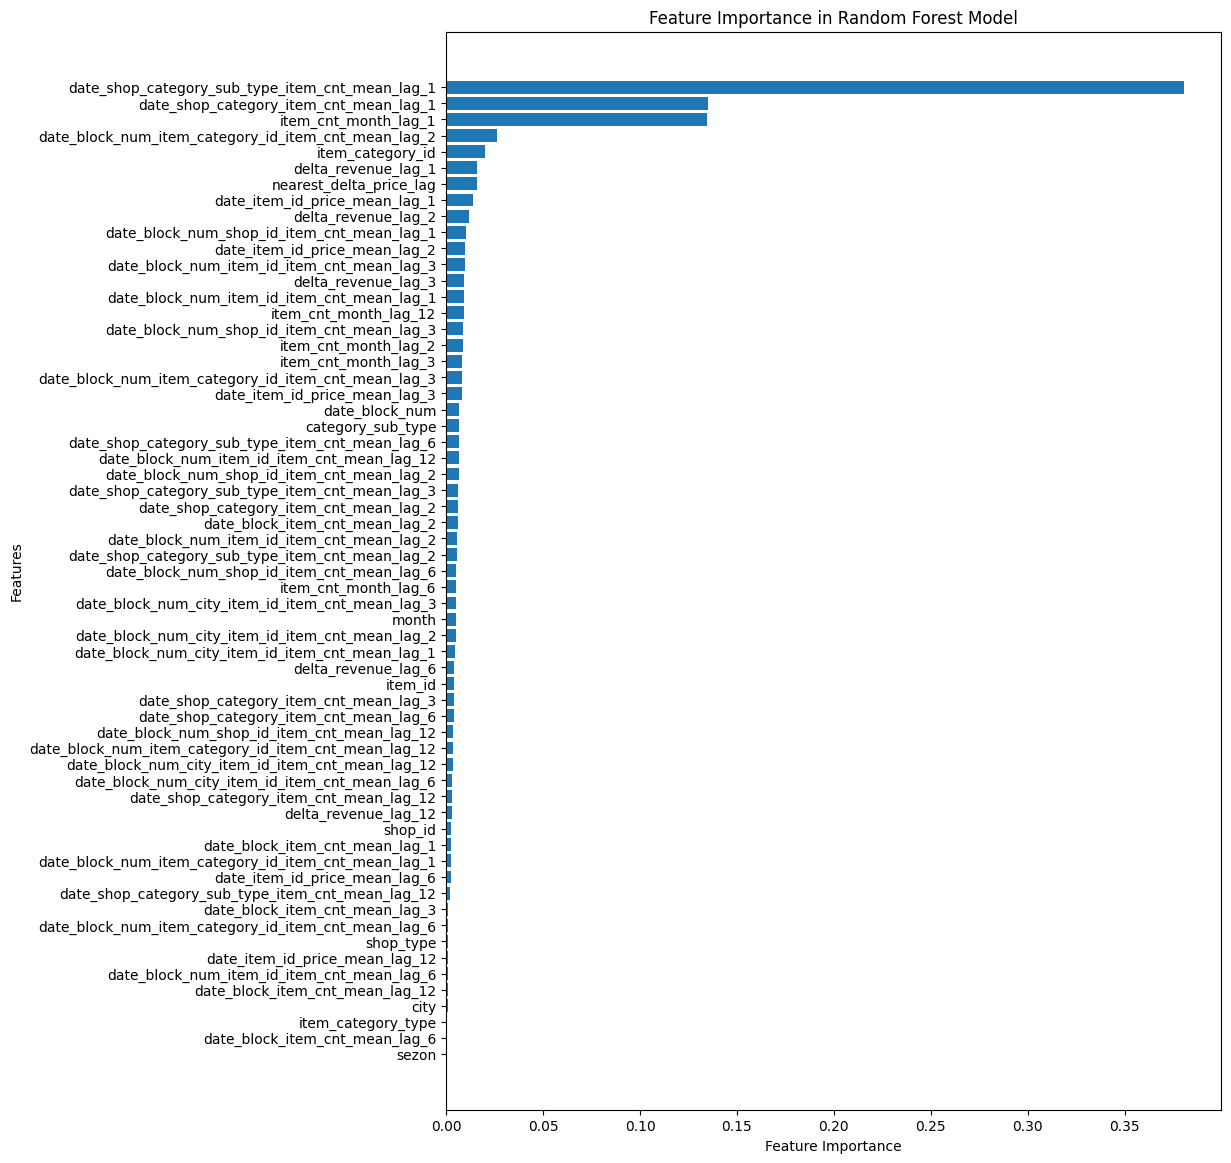

In [28]:
plt.figure(figsize=(10, 14))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

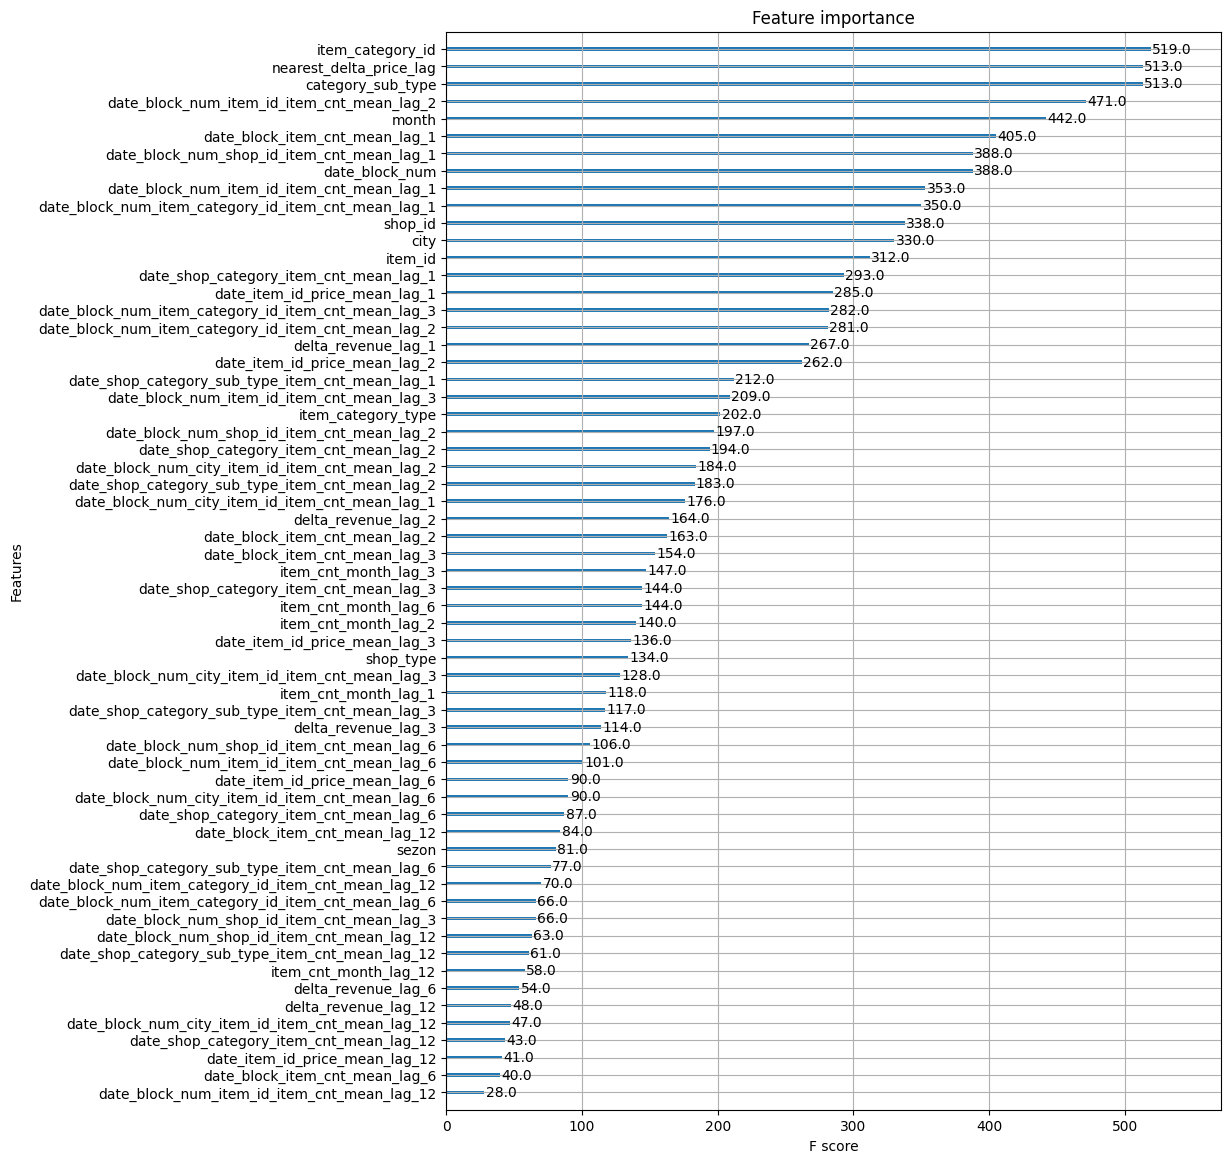

In [76]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

from xgboost import plot_importance
plot_features(best_xgb_model, (10,14))


**The random forest model relies more on lagged features while xgbost understands categorical features better.**

# Explainability layer

In [147]:
X_sampled = X_train.sample(10000, random_state=10)
X_sampled

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
8864556,25,30,8436,49,1.0,40.0,13.0,3.0,0.0,0.0,...,249.0000,244.5,0.009117,0.279297,0.669922,0.619141,0.003265,0.025589,1,0
6961950,19,28,13941,37,5.0,4.0,13.0,3.0,1.0,0.0,...,126.9375,98.0,0.165161,-0.113098,-0.024048,-0.056091,-0.050751,-0.241821,7,1
5465601,14,54,4836,20,0.0,14.0,26.0,3.0,0.0,0.0,...,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
7880791,22,22,14350,40,5.0,7.0,13.0,4.0,0.0,0.0,...,185.5000,399.0,-0.711426,0.155640,0.262451,-0.170654,0.048859,0.563965,10,2
9470347,27,44,4694,57,2.0,11.0,20.0,3.0,0.0,0.0,...,299.0000,299.0,0.107422,0.060669,0.147949,0.080872,0.227051,-0.102234,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5227855,14,13,19812,38,5.0,4.0,8.0,3.0,0.0,0.0,...,1333.0000,0.0,0.026016,0.270752,0.563965,0.076416,-0.270752,0.000000,2,0
10440228,31,56,15835,40,5.0,7.0,27.0,2.0,2.0,1.0,...,188.1250,197.0,0.056000,-0.048065,0.086060,0.329346,0.130005,-0.154297,7,1
4850891,13,4,2072,19,0.0,13.0,2.0,3.0,0.0,0.0,...,2672.0000,0.0,-0.127441,0.077332,0.219849,0.361328,-0.315186,0.000000,1,0
8520314,24,22,31,37,5.0,4.0,13.0,4.0,1.0,0.0,...,411.2500,499.0,-0.216064,0.279785,0.561035,0.155640,-0.227051,-0.281982,0,0


In [144]:
import shap
shap_test = shap.TreeExplainer(best_xgb_model).shap_values(X_sampled)
shap.summary_plot(shap_test, X_sampled,
                      max_display=25, auto_size_plot=True)

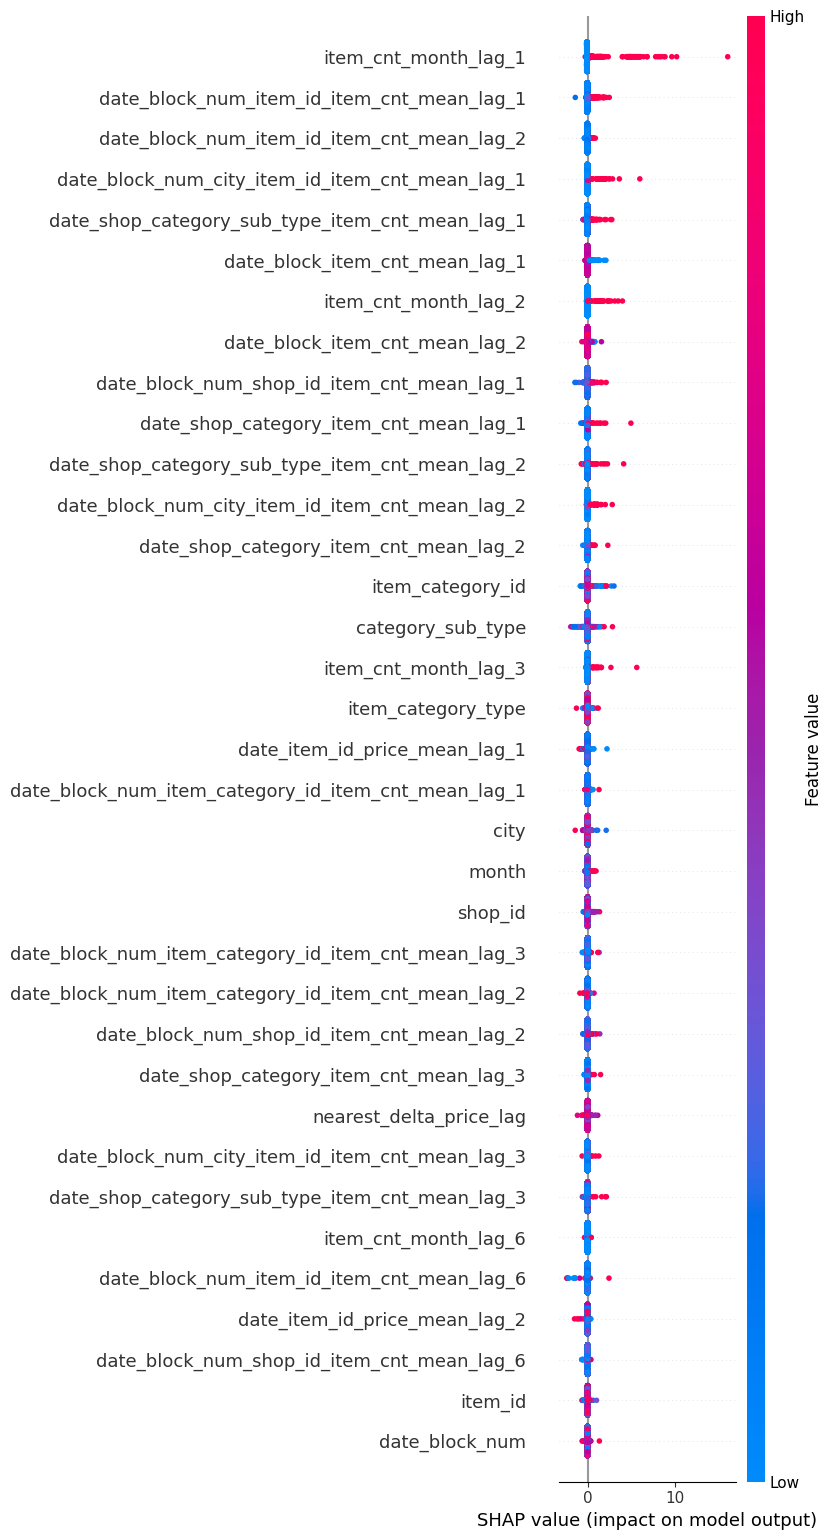

In [145]:
shap.summary_plot(shap_test, X_sampled, max_display=35)

**high values ​​of lagged variables contribute to a higher number in the prediction; the influence of categorical features is difficult to interpret**

# Error analys

## Error calculation

In [158]:
df = final_df[final_df.date_block_num < 34]

In [159]:
X = df.drop(['item_cnt_month'], axis=1)
Y_real = df['item_cnt_month']

In [161]:
X

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
4488710,12,2,27,19,2.0,13.0,0.0,4.0,0.0,0.0,...,1398.00,2324.0,-0.282715,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488711,12,2,30,40,1.0,7.0,0.0,4.0,0.0,0.0,...,385.50,0.0,-0.483398,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488712,12,2,31,37,1.0,4.0,0.0,4.0,0.0,0.0,...,699.00,0.0,-0.137451,0.453613,0.616699,0.010620,-0.336182,0.000000,0,0
4488713,12,2,32,40,1.0,7.0,0.0,4.0,0.0,0.0,...,346.00,338.0,-0.407227,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
4488714,12,2,33,37,1.0,4.0,0.0,4.0,1.0,2.0,...,195.50,488.5,-0.225464,0.453613,0.616699,0.010620,-0.336182,-0.402344,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10913799,33,59,22162,40,1.0,7.0,29.0,4.0,0.0,1.0,...,379.25,0.0,-0.085815,0.312744,-0.043762,-0.130859,0.228149,0.000000,9,2
10913800,33,59,22163,40,1.0,7.0,29.0,4.0,0.0,0.0,...,0.00,0.0,0.026581,0.312744,-0.043762,0.000000,0.000000,0.000000,9,2
10913801,33,59,22164,37,1.0,4.0,29.0,4.0,0.0,0.0,...,719.00,0.0,-0.230591,0.312744,-0.043762,-0.130859,0.228149,0.000000,9,2
10913802,33,59,22166,54,3.0,62.0,29.0,4.0,0.0,0.0,...,150.00,150.0,0.000000,0.312744,-0.043762,-0.130859,0.228149,0.241211,9,2


In [162]:
Y_predict = best_xgb_model.predict(X)

In [163]:
error = Y_real - Y_predict
abs_error = np.abs(error)

## How my model predict small - large target

In [164]:
Y_real = Y_real.astype('float32')
abs_error = abs_error.astype('float32')

max_val = Y_real.max() + 1
bins = [0, 10, 50, 100, max_val]
bin_labels = ['small', 'medium', 'large', 'very large']

y_val_binned = pd.cut(Y_real, bins=bins, labels=bin_labels, include_lowest=True)

error_df = pd.DataFrame({'error': abs_error, 'bin': y_val_binned})


error_by_bin = error_df.groupby('bin')['error'].mean()
print("Mean absolute error by target size:")
print(error_by_bin)

Mean absolute error by target size:
bin
small           0.301750
medium         11.500940
large          43.074787
very large    147.093246
Name: error, dtype: float32


C:\Users\Asus\AppData\Local\Temp\ipykernel_20608\3500316219.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = error_df.groupby('bin')['error'].mean()


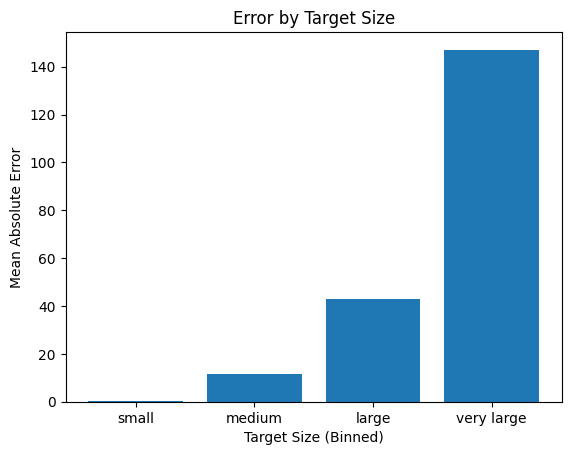

In [165]:
plt.bar(error_by_bin.index, error_by_bin.values)
plt.xlabel("Target Size (Binned)")
plt.ylabel("Mean Absolute Error")
plt.title("Error by Target Size")
plt.show()

## How my model predict target with small - large dinamic

In [218]:
col= []
for i in range(1, 4):
    col.append(f'item_cnt_month_lag_{i}')
df = X[col]
df = df.assign(item_cnt_month_lag_0=Y_real)
df = df.assign(abs_error=abs_error)
df

,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_0,abs_error
4488710,0.0,0.0,0.0,0.0,0.060563
4488711,0.0,0.0,0.0,0.0,0.110270
4488712,0.0,0.0,0.0,0.0,0.120428
4488713,0.0,0.0,0.0,1.0,0.854285
4488714,1.0,2.0,0.0,1.0,0.694591
...,...,...,...,...,...
10913799,0.0,1.0,0.0,0.0,0.168018
10913800,0.0,0.0,0.0,0.0,0.177113
10913801,0.0,0.0,1.0,0.0,0.193034
10913802,0.0,0.0,0.0,0.0,0.012150


In [237]:
cols = ['item_cnt_month_lag_0', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'abs_error']
df = df[cols]

df = df[~((df['item_cnt_month_lag_0'] == 0) & (df['item_cnt_month_lag_1'] == 0) & (df['item_cnt_month_lag_2'] == 0) & (df['item_cnt_month_lag_3'] == 0))]

df['pct_change_lag0_lag1'] = (df['item_cnt_month_lag_1'] - df['item_cnt_month_lag_0']).div(df['item_cnt_month_lag_0'].replace(0, 1)) * 100
df['pct_change_lag1_lag2'] = (df['item_cnt_month_lag_2'] - df['item_cnt_month_lag_1']).div(df['item_cnt_month_lag_1'].replace(0, 1)) * 100
df['pct_change_lag2_lag3'] = (df['item_cnt_month_lag_3'] - df['item_cnt_month_lag_2']).div(df['item_cnt_month_lag_2'].replace(0, 1)) * 100




error_analysis_results = {}


for threshold in range(0, 160, 5):

    df['small_dynamic'] = (
    (df[['pct_change_lag0_lag1', 'pct_change_lag1_lag2', 'pct_change_lag2_lag3']].abs().mean(axis=1) >= threshold) &
    (df[['pct_change_lag0_lag1', 'pct_change_lag1_lag2', 'pct_change_lag2_lag3']].abs().mean(axis=1) <= threshold + 5))

    small_dynamic_error = df[df['small_dynamic'] == True]['abs_error'].mean()

    error_analysis_results[threshold] = {
        'small_dynamic_error': small_dynamic_error
    }

for threshold, errors in error_analysis_results.items():
    print(f"Dinamic: {threshold} - {threshold+5} %")
    print(f"MAE: {errors['small_dynamic_error']}")
    print("-" * 50)


Dinamic: 0 - 5 %
MAE: 0.5582060813903809
--------------------------------------------------
Dinamic: 5 - 10 %
MAE: 11.82346248626709
--------------------------------------------------
Dinamic: 10 - 15 %
MAE: 5.5518107414245605
--------------------------------------------------
Dinamic: 15 - 20 %
MAE: 2.097383975982666
--------------------------------------------------
Dinamic: 20 - 25 %
MAE: 4.578510761260986
--------------------------------------------------
Dinamic: 25 - 30 %
MAE: 3.0998668670654297
--------------------------------------------------
Dinamic: 30 - 35 %
MAE: 0.8414708971977234
--------------------------------------------------
Dinamic: 35 - 40 %
MAE: 3.362637519836426
--------------------------------------------------
Dinamic: 40 - 45 %
MAE: 2.8489391803741455
--------------------------------------------------
Dinamic: 45 - 50 %
MAE: 1.3874224424362183
--------------------------------------------------
Dinamic: 50 - 55 %
MAE: 1.3929004669189453
------------------------

In [238]:
error_analysis_results_df = pd.DataFrame(error_analysis_results)
error_analysis_results_df

,0,5,10,15,20,25,30,35,40,45,...,110,115,120,125,130,135,140,145,150,155
small_dynamic_error,0.558206,11.823462,5.551811,2.097384,4.578511,3.099867,0.841471,3.362638,2.848939,1.387422,...,1.33759,0.961001,1.135302,1.705606,0.803355,2.128891,1.437873,1.324769,1.325813,1.231937


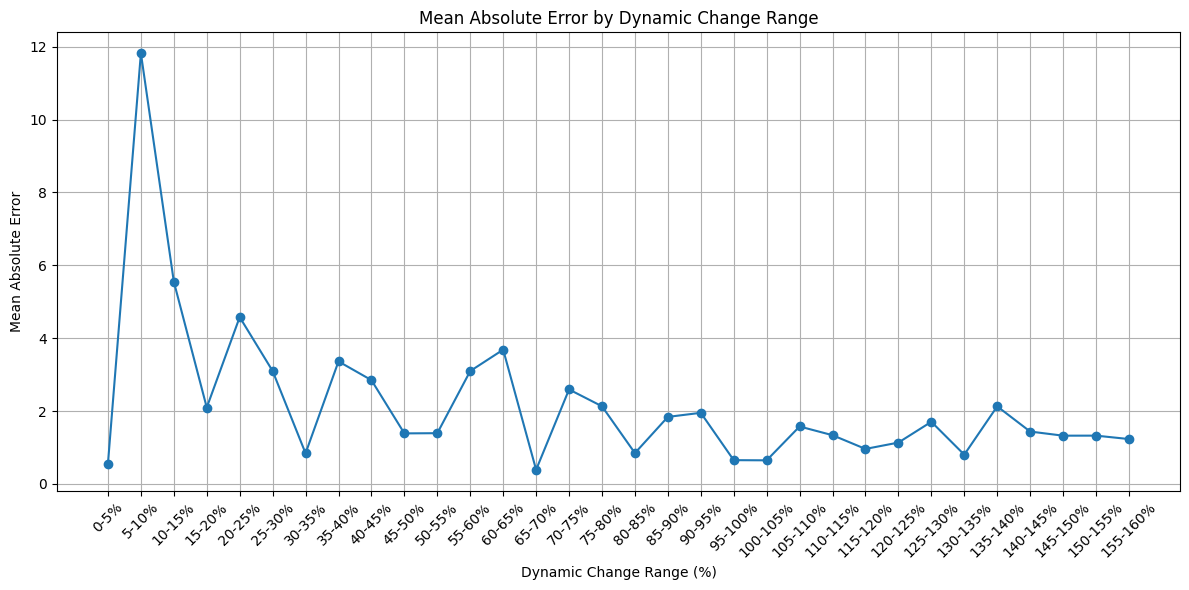

In [239]:
dynamic_ranges = [f"{i}-{i+5}%" for i in range(0, 160, 5)]

plt.figure(figsize=(12, 6))
plt.plot(dynamic_ranges, error_analysis_results_df.loc['small_dynamic_error'], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel("Dynamic Change Range (%)")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error by Dynamic Change Range")
plt.grid(True)
plt.tight_layout()
plt.show()

**The graph shows that examples with low dynamics are worse predicte**

## Find the samples with the highest errors

In [241]:
top_errors = abs_error.sort_values(ascending=False).head(160)
print("Top 10 samples with highest absolute errors:")
top_errors.head(10)

Top 10 samples with highest absolute errors:


10494631    1589.388062
10652267    1568.150513
9530323     1235.258789
8706158     1070.086914
7755717     1070.040039
10652269    1034.838501
8256138      926.091125
5644753      893.945496
7193978      847.947937
9344140      800.340210
Name: item_cnt_month, dtype: float32

In [243]:
high_error_samples = X.loc[top_errors.index]
high_error_samples

,date_block_num,shop_id,item_id,item_category_id,item_category_type,category_sub_type,city,shop_type,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_id_price_mean_lag_6,date_item_id_price_mean_lag_12,nearest_delta_price_lag,delta_revenue_lag_1,delta_revenue_lag_2,delta_revenue_lag_3,delta_revenue_lag_6,delta_revenue_lag_12,month,sezon
10494631,32,12,9248,80,1.0,28.0,7.0,0.0,19.0,12.0,...,0.000000,0.000000,-0.046844,-0.541016,-0.426025,-0.392822,0.000000,0.000000,8,2
10652267,32,55,9249,8,1.0,0.0,7.0,0.0,19.0,12.0,...,0.000000,0.000000,-0.046173,-0.060059,-0.250000,-0.090759,0.000000,0.000000,8,2
9530323,27,55,3730,31,2.0,62.0,7.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,0
8706158,24,55,5917,31,2.0,62.0,7.0,0.0,50.0,3.0,...,199.000000,0.000000,-0.533203,0.429443,0.282715,0.497314,-0.504395,0.000000,0,0
7755717,21,55,19437,31,2.0,62.0,7.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7116836,19,54,20949,71,5.0,59.0,26.0,4.0,450.0,379.0,...,4.886719,4.894531,-0.004768,-0.162231,0.057098,0.022232,0.017685,-0.349609,7,1
6092674,16,48,20949,71,5.0,59.0,23.0,3.0,45.0,0.0,...,0.000000,0.000000,-0.005566,-0.270264,0.000000,0.000000,0.000000,0.000000,4,1
9898557,29,31,20949,71,5.0,59.0,13.0,4.0,460.0,481.0,...,4.937500,4.890625,0.014305,0.211426,0.169312,-0.022049,0.499023,-0.146240,5,1
5635423,15,25,20949,71,5.0,59.0,13.0,2.0,107.0,192.0,...,4.871094,4.898438,-0.007950,0.018921,-0.062744,-0.236450,-0.051605,-0.378662,3,0


In [244]:
high_error_samples.shop_id.value_counts()

shop_id
12    29
55    27
31    25
25    23
42    11
28     9
54     8
27     6
57     3
9      3
47     3
6      2
38     1
48     1
37     1
14     1
22     1
18     1
26     1
29     1
43     1
24     1
15     1
Name: count, dtype: int64

**This is completely logical since id 55 corresponds to a "цифрой скла", and id 12 to an online store**

In [246]:
high_error_samples.item_id.value_counts()

item_id
20949    73
3731     11
11370     7
11373     5
3733      4
2814      4
7967      4
10210     4
9242      4
10209     3
8057      2
19437     2
3025      2
7966      2
19445     2
19446     2
6502      2
5917      2
9241      2
10199     1
10212     1
11369     1
1875      1
6675      1
3729      1
7794      1
4392      1
4201      1
2042      1
9248      1
9243      1
19436     1
9249      1
9255      1
9253      1
9252      1
9245      1
9244      1
9247      1
9251      1
3730      1
9250      1
Name: count, dtype: int64

**The errors are completely logical because id 20949 is the id of packages, and all ids starting with 9 are tickets**

In [249]:
high_error_samples.item_category_id.value_counts()

item_category_id
71    73
31    15
8     13
30    13
9     13
28     9
20     8
34     6
80     4
32     2
29     2
75     1
12     1
Name: count, dtype: int64

**This is also logical because id 71 are gifts and during a holiday, for example, large companies purchase large quantities**

# Creating submission

In [192]:
test_inputs = final_df[final_df['date_block_num']==34].copy()
test_inputs = test_inputs.drop(['item_cnt_month'], axis=1)
test_preds = best_xgb_model.predict(test_inputs)

In [193]:
data['sub_data']['item_cnt_month'] = test_preds.clip(0,20)
data['sub_data'].to_csv('../data/submission8.csv', index=None)